In [3]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

Start time of execution

In [4]:
time_start = time()

## Load configuration

In [5]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
client = pymongo.MongoClient(config["client"])
db = client[config["db"]]
coll = db[config["col"]]
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A']


## Apply filter

In [7]:
# Sample code to apply filters on data fetched from MongoDB
data_cursor = coll.find()
data_list = list(data_cursor)

data_df_list = [pd.DataFrame(doc['data']) for doc in data_list]

filtered_data = filter_instances(data_df_list, order=config['filter']['order'], wn=config['filter']['wn'], filter_type=config['filter']['type'])

Number of filtered instances in the list: 2


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [8]:
# Sample code to transform DataFrames to NumPy arrays
np_data_list = [df.to_numpy() for df in filtered_data]

# Assuming `sliding_window_pd` is already defined in utils, apply it here
windows_list = [sliding_window_pd(pd.DataFrame(data), ws=config['sliding_window']['ws'], overlap=config['sliding_window']['overlap']) for data in np_data_list]

# Flatten the list of lists
windows = [window for sublist in windows_list for window in sublist]

## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [9]:
# Sample code to flatten the window instances
windows_flattened = [flatten_instances_df(windows) for windows in windows_list]

# Combine all windows into a single DataFrame
all_windows_flattened = pd.concat(windows_flattened, ignore_index=True)

# Extract features and labels
X = all_windows_flattened.iloc[:, :-1].values
y = all_windows_flattened.iloc[:, -1].values

## Train/Test split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

## Scaling

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
# Sample code for scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [13]:
# add transformers
from sklearn.decomposition import PCA

TypeError: plot_scatter_pca() got an unexpected keyword argument 'title'

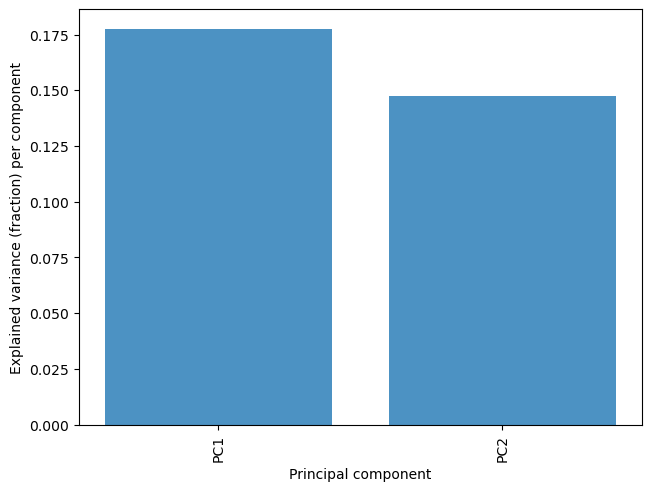

In [17]:
# PCA with 2 components
pca2d = PCA(n_components=2)
X_train_2d = pca2d.fit_transform(X_train_scaled)
X_test_2d = pca2d.transform(X_test_scaled)

pca_explained_variance_bar(pca2d, alpha=0.8)
plot_scatter_pca(X_train_2d, y_train, title='PCA 2D Scatter Plot')

### PCA with 3 Components

In [ ]:
pca3d = PCA(n_components=3)
X_train_3d = pca3d.fit_transform(X_train_scaled)
X_test_3d = pca3d.transform(X_test_scaled)

plot_instance_3d(X_train_3d, y_train)

### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [ ]:
pca_var = PCA(n_components=0.95)  # Adjust the variance percentage as needed
X_train_var = pca_var.fit_transform(X_train_scaled)
X_test_var = pca_var.transform(X_test_scaled)

## Classifier - Statistical Learning

### Apply simple classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize and train the SVC classifier
svc = SVC(kernel='rbf', C=config['classifier']['SVC']['C'], gamma=config['classifier']['SVC']['gamma'])
svc.fit(X_train_var, y_train)

### Evaluate simple classifier

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Evaluate the classifier
y_pred = svc.predict(X_test_var)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))

### Apply optimization with Grid Search and Cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define parameter grid
param_grid = config['fine_tune']['param_grid']

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=config['fine_tune']['cv'], verbose=config['fine_tune']['verbose'])

# Fit the model
grid_search.fit(X_train_var, y_train)

### Evaluate optimized classifier

In [ ]:
# Evaluate the optimized classifier
best_svc = grid_search.best_estimator_
y_pred_optimized = best_svc.predict(X_test_var)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
disp_optimized.plot()
plt.show()

print(classification_report(y_test, y_pred_optimized))

## Classifier - Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [ ]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = Sequential()

# Add layers to the model
model.add(Dense(64, activation='relu', input_shape=X_train_2d.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

Plot the Architecture of the TensorFlow model

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Plot the summary of the TensorFlow model

In [ ]:
model.summary()

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
from utils import encode_labels
y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

### Train the NN model

In [ ]:
history = model.fit(X_train_2d, y_train_encoded, epochs=config['fit']['epochs'], batch_size=config['fit']['batch'], validation_split=0.2, verbose=config['fit']['verbose'])

### Evaluate the model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(X_test_2d, y_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# End time of execution
time_end = time()
print(f"Total execution time: {time_end - time_start:.2f} seconds")